### Comments

**TO DO**
* Batch?!
* fine tuning des params --> pas optimisé pour le moment => optimisation done parametres semblables a avant
* try different architecture -> testé combinaison de linear et GCNN / APPNP => GCNN avec une linear avant et deux linear apres = best
* Use genre as features and build network on Cast, Crew, Keywords?
* Skip Connections ? Batch Norm ? 
* Standardiser ameliores performances et balance des errors + stabilise learning

# Machine Learning

In [1]:
import numpy as np
import pandas as pd
import pickle

import sklearn.metrics
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, precision_score, precision_recall_fscore_support
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

import random

import dgl.function as fn
from dgl import DGLGraph
import dgl.nn.pytorch as dgl_nn
import dgl.transform as dgl_transform

import time

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

Data_path = 'Data/'

### Loading the similarity matrix and generate graph

In [2]:
# Load similarity matrix
#file = open(Data_path + 'Adjacency_matrix.pickle','rb')
#file = open(Data_path + 'Adjacency_matrix_G99CCK05.pickle', 'rb')
file = open(Data_path + 'Adjacency_matrix_all025.pickle', 'rb')
adj_mat =  pickle.load(file)

# Generate graph
G = DGLGraph(graph_data=adj_mat)
#G = dgl_transform.add_self_loop(G)

### Loading features and labels

In [3]:
# features
features_df = pd.read_csv(Data_path + 'features.csv',index_col=0).drop(columns = ['title'])
features_df = features_df[['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']]

# labels
labels_df = pd.read_csv(Data_path + 'labels.csv',index_col=0).drop(columns = ['title', ])
IMDB_nom = labels_df['Nominations'].copy()
IMDB_nom.loc[IMDB_nom > 0] = 1
# Checking class imbalance
IMDB_nom.value_counts() # 18.263 % of CLASS 1

0.0    3728
1.0    1074
Name: Nominations, dtype: int64

### Generate masks and split train, val, test

In [4]:
sss1 = StratifiedShuffleSplit(n_splits=1, train_size=0.8, random_state=0)
sss2 = StratifiedShuffleSplit(n_splits=1, train_size=0.8, random_state=0)

for prov_index, test_index in sss1.split(features_df, IMDB_nom.values):
    prov_mask = prov_index
    test_mask = test_index

for train_index, val_index in sss2.split(features_df.iloc[prov_mask], IMDB_nom.values[prov_mask]):
    train_mask = train_index
    val_mask = val_index

### Standardize and create tensors

In [5]:
# Standardizing the data increases performances (73 -> 82), in terms of repartition bit more imbalanced
# but still increase of performance for class 1 samples
scaler = StandardScaler()
features_df.iloc[train_mask] = scaler.fit_transform(features_df.iloc[train_mask].to_numpy())
features_df.iloc[val_mask] = scaler.transform(features_df.iloc[val_mask].to_numpy())
features_df.iloc[test_mask] = scaler.transform(features_df.iloc[test_mask].to_numpy())

In [6]:
# features
tensor_data = torch.FloatTensor(features_df.values)

# labels
tensor_labels = torch.LongTensor(IMDB_nom.values)

### Building Logistic Regression

In [7]:
# PCA without feature selection not significant impact
#pca = PCA(n_components=features_df.shape[1])
#features_df.iloc[train_mask] = pca.fit_transform(features_df.iloc[train_mask].to_numpy())
#features_df.iloc[val_mask] = pca.transform(features_df.iloc[val_mask].to_numpy())

In [8]:
clf = LogisticRegression(C= 1,random_state = 0,solver = 'lbfgs').fit(features_df.iloc[train_mask].to_numpy(),IMDB_nom.values[train_mask])
train_pred = clf.predict(features_df.iloc[train_mask].to_numpy())
val_pred = clf.predict(features_df.iloc[val_mask].to_numpy())

#print('>>>>> Training Accuracy of Logistic Regression: {:0.4}'.format(train_score))
#print('>>>>> Validation Accuracy of Logistic Regression: {:0.4}'.format(val_score))
#print('>>>>> Proportion of validation class 1: {:0.4}'.format(np.sum(IMDB_nom.values[val_mask])/len(IMDB_nom.values[val_mask])))
#print('>>>>> Proportion of predicted class 1: {:0.4}'.format(np.sum(clf.predict(features_df.iloc[val_mask]))/len(IMDB_nom.values[val_mask])))

tr_pre,tr_rec,tr_f1,tr_sup = precision_recall_fscore_support(train_pred,IMDB_nom.values[train_mask])
print('Training set:')
print('>>> Precision: {:0.4}'.format(tr_pre[1]))
print('>>> Recall: {:0.4}'.format(tr_rec[1]))
print('>>> F1: {:0.4}'.format(tr_f1[1]))
print('>>> Support: {:}'.format(tr_sup[1]))
print('')

val_pre,val_rec,val_f1,val_sup = precision_recall_fscore_support(val_pred,IMDB_nom.values[val_mask])
print('Validation set:')
print('>>> Precision: {:0.4}'.format(val_pre[1]))
print('>>> Recall: {:0.4}'.format(val_rec[1]))
print('>>> F1: {:0.4}'.format(val_f1[1]))
print('>>> Support: {:}'.format(val_sup[1]))

Training set:
>>> Precision: 0.1576
>>> Recall: 0.7126
>>> F1: 0.2581
>>> Support: 167

Validation set:
>>> Precision: 0.1474
>>> Recall: 0.6222
>>> F1: 0.2383
>>> Support: 45


In [9]:
# Confusion Matrix on validation classification
#disp = sklearn.metrics.plot_confusion_matrix(clf, features_df.iloc[val_mask],IMDB_nom.values[val_mask],cmap=plt.cm.Blues,display_labels = ['Not Nominated','Nominated'],normalize='true')


### Building Logistic Regression & Graph Filtering

##### Results of optimisation : 

Optimisation performed by looking at validation accuracy and distribution of errors across classes using confusion matrix
- polynomial order : increase of the order tends to increase the instability of performances accross epochs, no strong impact on filter final shape -> tradeoff complexity/stability at 3
- learning rate: small shift towards very unbalanced error, higher learning rate enabled to get a better trade-off between accuracy and distribution of error -> 0.2
- number of epochs : event of strong instabilities across trials whatever parameters; strong instabilities allows better balance of errors but weaker accuracies; around 1500 period of stable learning
- dropout : increase generates instabilities, tradeoff between accuracy and distribution of errors at 0.
=> Final filter is basically always the same sort of shape as shown below

In [10]:
# Plot confusion matrix when classifier not available only confusion matrix
def confusion_matrix(matrix):
    figure = plt.figure()
    axes = figure.add_subplot(111)
    test = axes.matshow(matrix, cmap = plt.cm.get_cmap('Blues'));
    axes.set_yticklabels(['','Not Nominated','Nominated'],style='italic')
    axes.set_xticklabels(['','Not Nominated','Nominated'],style='italic')
    axes.set_ylabel('True Label')
    axes.set_xlabel('Predicted Label')
    figure.colorbar(test)
    for (j,i),label in np.ndenumerate(matrix):
        axes.text(i,j,np.round(label,3),ha='center',va='center',color = 'grey')
    plt.show()

In [11]:
class LaplacianPolynomial(nn.Module):
    def __init__(self,
                 in_feats: int,
                 out_feats: int,
                 k: int,
                 dropout_prob: float,
                 norm=True):
        super().__init__()
        self._in_feats = in_feats
        self._out_feats = out_feats
        self._k = k
        self._norm = norm
        # Contains the weights learned by the Laplacian polynomial
        self.pol_weights = nn.Parameter(torch.Tensor(self._k + 1))
        # Contains the weights learned by the logistic regression (without bias)
        self.logr_weights = nn.Parameter(torch.Tensor(in_feats, out_feats))
        self.dropout = nn.Dropout(p=dropout_prob)
        self.reset_parameters()

    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        torch.manual_seed(0)
        torch.nn.init.xavier_uniform_(self.logr_weights, gain=0.01)
        torch.nn.init.normal_(self.pol_weights, mean=0.0, std=1e-3)

    def forward(self, graph, feat):
        r"""Compute graph convolution.

        Notes
        -----
        * Input shape: :math:`(N, *, \text{in_feats})` where * means any number of additional
          dimensions, :math:`N` is the number of nodes.
        * Output shape: :math:`(N, *, \text{out_feats})` where all but the last dimension are
          the same shape as the input.

        Parameters
        ----------
        graph (DGLGraph) : The graph.
        feat (torch.Tensor): The input feature

        Returns
        -------
        (torch.Tensor) The output feature
        """
        feat = self.dropout(feat)
        graph = graph.local_var()
        
        # D^(-1/2)
        norm = torch.pow(graph.in_degrees().float().clamp(min=1), -0.5)
        shp = norm.shape + (1,) * (feat.dim() - 1)
        norm = torch.reshape(norm, shp)

        # mult W first to reduce the feature size for aggregation.
        feat = torch.matmul(feat, self.logr_weights) # X*Teta

        result = self.pol_weights[0] * feat.clone() # a0*L^0*X*Teta <-- fisrt polynomial weight a0 * L^0 * x

        for i in range(1, self._k + 1): # get the next polynomial coefficient (a1*L^1, a2*L^2, ..... ak*L^k) 
            old_feat = feat.clone()
            if self._norm:
                feat = feat * norm
            graph.ndata['h'] = feat
            # Feat is not modified in place
            graph.update_all(fn.copy_src(src='h', out='m'),
                             fn.sum(msg='m', out='h')) # update all nodes with msg function copy_src (get data from source node) and reduce function sum
            if self._norm:
                graph.ndata['h'] = graph.ndata['h'] * norm

            feat = old_feat - graph.ndata['h']
            result += self.pol_weights[i] * feat

        return result

    def extra_repr(self):
        """Set the extra representation of the module,
        which will come into effect when printing the model.
        """
        summary = 'in={_in_feats}, out={_out_feats}'
        summary += ', normalization={_norm}'
        return summary.format(**self.__dict__)

In [12]:
def train(model, g, features, labels, train_mask, loss_fcn, optimizer):
    """ 
    DESCRIPTION : Train and update model classification performances with training set
    INPUT:
        |--- model: [] classification model to train
        |--- g: [DGLgraph] DeepGraphLearning graph object
        |--- features: [FloatTensor] 2D tensor containing samples' features
        |--- labels: [LongTensor] 1D tensor containing samples' labels (0-1)
        |--- train_mask: [np.array] indices of training set
        |--- loss_fcn: pytorch loss function chosen for model training
        |--- optimizer: pytorch model optimizer 
    OUTPUT:
        |--- loss: [float] value of loss function for the model at current state
    """
    model.train()  
    
    pred = model(g, features)[train_mask] # prediction
    loss = loss_fcn(pred, labels[train_mask])
    optimizer.zero_grad()    
    loss.backward()

    optimizer.step()
    #_, indices = torch.max(pred, dim=1)
    #correct = torch.sum(indices == labels[train_mask])
    #acc = correct.item() * 1.0 / len(labels[train_mask]) #not the best metric
    
    #C = sklearn.metrics.confusion_matrix(tensor_labels[train_mask], indices.numpy(), labels=[0,1], sample_weight=None, normalize='true')

    #return loss, acc, C
    return loss
    
def evaluate(model, g, features, mask, labels):
    """ 
    DESCRIPTION : Evaluate model classification performance on validation set 
    INPUT:
        |--- model: [] classification model to evaluate
        |--- g: [DGLgraph] DeepGraphLearning graph object
        |--- features: [FloatTensor] 2D tensor containing samples' features
        |--- labels: [LongTensor] 1D tensor containing samples' labels (0-1)
        |--- mask: [np.array] indices of validation set
    OUTPUT:
        |--- acc: [float] classification accuracy
        |--- recall: [float] classification recall
        |--- precision: [float] classification precision
        |--- f1: [float] classification f1 score
    """
    model.eval() 
    
    with torch.no_grad():
        pred = model(g, features)[mask]  # only compute the evaluation set
        labels = labels[mask]
        _, indices = torch.max(pred, dim=1)
        
        pre,rec,f1,sup = precision_recall_fscore_support(labels,indices.numpy())
        #correct = torch.sum(indices == labels)
        #acc = correct.item() * 1.0 / len(labels) #not the best metric
        #f1 = f1_score(labels, indices)
        #recall = recall_score(labels, indices)
        #precision = precision_score(labels, indices)
        
        C = sklearn.metrics.confusion_matrix(labels, indices.numpy())
        
        return pre[1], rec[1], f1[1], sup[1], C

In [13]:
pol_order = 3  # seems like a good trade off between performance and instability, increasing does give more
lr = 0.3 # allows to get a good tradeoff between error distribution and accuracy
weight_decay = 5e-6
n_epochs = 500 
p_dropout = 0.32  # 0.32 very good balancing, 75%, 0.3 balacing a bit less, 77%
n_classes = 2
in_feats=tensor_data.shape[1]

Epoch 00050 | Train Loss 1323.2120 | Precision 25.8860% | Recall 88.4211%
Epoch 00100 | Train Loss 168.1663 | Precision 36.3636% | Recall 10.5263%
Epoch 00150 | Train Loss 8.1099 | Precision 28.3465% | Recall 18.9474%
Epoch 00200 | Train Loss 0.7820 | Precision 42.8571% | Recall 18.9474%
Epoch 00250 | Train Loss 0.7422 | Precision 50.0000% | Recall 14.2105%
Epoch 00300 | Train Loss 0.5616 | Precision 43.3962% | Recall 24.2105%
Epoch 00350 | Train Loss 0.5661 | Precision 49.1525% | Recall 15.2632%
Epoch 00400 | Train Loss 0.5600 | Precision 46.1538% | Recall 15.7895%
Epoch 00450 | Train Loss 0.6357 | Precision 46.2687% | Recall 16.3158%
Epoch 00500 | Train Loss 0.5607 | Precision 43.0380% | Recall 17.8947%

Test


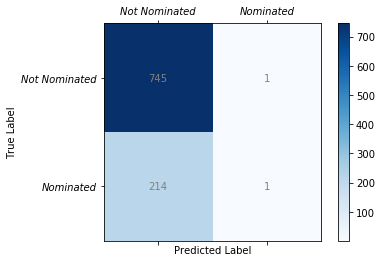

Precision 50.0000% | Recall 0.4651%


In [14]:
model = LaplacianPolynomial(in_feats, n_classes, pol_order, p_dropout)

loss_fcn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=lr,
                             weight_decay=weight_decay)

losses = []
accuracies_val = []
accuracies_tr = []
for epoch in range(n_epochs):

    loss = train(model, G, tensor_data, tensor_labels, train_mask, loss_fcn, optimizer)
    losses.append(loss)
    #accuracies_tr.append(acc)

    pre, rec, f1, sup, C = evaluate(model, G, tensor_data, val_mask, tensor_labels)
    #accuracies_val.append(acc)
    if (epoch+1)%50 == 0:
        print("Epoch {:05d} | Train Loss {:.4f} | Val precision {:.4%} | Val recall {:.4%}". format(epoch+1, loss.item(), pre, rec))

print()
print('Test')
pre, rec, f1, sup, C = evaluate(model, G, tensor_data, test_mask, tensor_labels)
confusion_matrix(C)
print("Precision {:.4%} | Recall {:.4%}". format(pre, rec))

# instabilite au file des epochs -> more balanced, less performant

In [15]:
def polynomial_graph_filter_response(coeff: np.array, lam: np.ndarray):
    """ 
        DESCRIPTION : Compute response of filtering using a polynomial filter 
        INPUT:
            |--- coeff: [np.array] coeffiicients of polynomial filter
            |--- lam: [np.ndarray] eigenvalues 
        OUTPUT:
            |--- response: [np.ndarray] response[i] is the spectral response at frequency lam[i]
    """
    V = np.vander(lam,coeff.shape[0],increasing=True)
    response = V@coeff
    return response

In [16]:
def spectral_decomposition(laplacian: np.ndarray):
    """ 
        DESCRIPTION : Compute spectral decomposition of a graph using the graph Laplacian
        INPUT:
            |--- laplacian: [np.ndarray] graph laplacian 
        OUTPUT:
            |--- lamb: [np.ndarray] containing graph eigenvalues
            |--- U: [np.ndarray] containing corresponding graph eigenvectors
    """
    # compute the eigenvalues and eigenvectors
    if np.allclose(laplacian, laplacian.T, 1e-12):
        lamb, U = np.linalg.eigh(laplacian)
    else:
        lamb, U = np.linalg.eig(laplacian)
        #sort them
        idx = np.argsort(lamb, axis=0)
        lamb = lamb[idx]
        U = U[:,idx]
    
    return lamb, U

In [17]:
def compute_laplacian(adjacency: np.ndarray, normalize: bool):
    """ 
        DESCRIPTION : Compute spectral decomposition of a graph using the graph Laplacian
        INPUT:
            |--- adjacency: [np.ndarray] adjacency matrix of the graph
            |--- normalize: [bool] if normalize laplacian or not
        OUTPUT:
            |--- L: [n x n ndarray] combinatorial or symmetric normalized Laplacian. of the graph 
    """
    # degrees
    I = np.identity(adjacency.shape[0])
    degree = np.sum(adjacency, axis=1)
    # Compute laplacian
    D = I.copy()
    np.fill_diagonal(D, degree)
    L = D - adjacency
    # normalized if requested 
    if normalize:
        D12 = np.where(D > 0, np.power(D, -0.5, where=D>0), 0)
        L = D12 @ L @ D12
        
    return L

In [18]:
L_norm = compute_laplacian(adjacency =adj_mat, normalize = True)
lamb_, _ = spectral_decomposition(laplacian = L_norm)

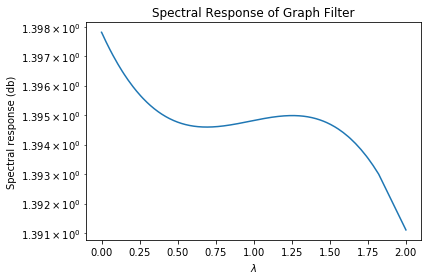

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogy(lamb_,np.abs(polynomial_graph_filter_response(model.pol_weights.detach().numpy(), lamb_)))
ax.set_xlabel('$\lambda$')
ax.set_ylabel('Spectral response (db)')
ax.set_title('Spectral Response of Graph Filter')
plt.show()

### Building Graph Neural Network

In [20]:
#  model: Combine GraphConv layers first then two fully connected layers --> seems less stable over epochs
class Linear_GNN(nn.Module):
    def __init__(self, in_feats: int, out_feats: int, hidden_size: int):
        super().__init__()
        self._in_feats = in_feats
        self._out_feats = out_feats
        self._hidden_size = 24
        
        # Layers --> as much GraphConv as diameter --> reach everywhere
        layer_size = 64
        self.linear = nn.Linear(self._in_feats, layer_size)
        self.gcn1 = dgl_nn.conv.GraphConv(layer_size, layer_size, activation=F.relu)
        self.gcn2 = dgl_nn.conv.GraphConv(layer_size, layer_size, activation=F.relu)
        self.gcn3 = dgl_nn.conv.GraphConv(layer_size, layer_size, activation=F.relu)
        self.gcn4 = dgl_nn.conv.GraphConv(layer_size, layer_size, activation=F.relu)
        self.gcn5 = dgl_nn.conv.GraphConv(layer_size, layer_size, activation=F.relu)
        self.gcn6 = dgl_nn.conv.GraphConv(layer_size, layer_size, activation=F.relu)
        self.gcn7 = dgl_nn.conv.GraphConv(layer_size, layer_size, activation=F.relu)
        self.gcn8 = dgl_nn.conv.GraphConv(layer_size, layer_size, activation=F.relu)
        self.gcn9 = dgl_nn.conv.GraphConv(layer_size, layer_size, activation=F.relu)
        self.gcn10 = dgl_nn.conv.GraphConv(layer_size, layer_size, activation=F.relu)
        self.gcn11 = dgl_nn.conv.GraphConv(layer_size, layer_size, activation=F.relu)
        self.linear1 = nn.Linear(layer_size, self._out_feats)
        #self.linear2 = nn.Linear(self._hidden_size, self._out_feats)
        
    def forward(self, graph, feat):
        h = F.relu(self.linear(feat))
        h = self.gcn1(graph, h)
        h = self.gcn2(graph, h)
        h = self.gcn3(graph, h)
        h = self.gcn4(graph, h)
        h = self.gcn5(graph, h)
        h = self.gcn6(graph, h)
        h = self.gcn7(graph, h)
        h = self.gcn8(graph, h)
        h = self.gcn9(graph, h)
        h = self.gcn10(graph, h)
        h = self.gcn11(graph, h)
        h = self.linear1(h)
        #h = F.relu(h)
        #h = self.linear2(h)
        h = F.log_softmax(h, dim=1)
        return h 

# Model : Only GraphConv layers --> seems more stable
class Pure_GNN(nn.Module):
    def __init__(self, in_feats: int, out_feats: int, hidden_size: int):
        super().__init__()
        self._in_feats = in_feats
        self._out_feats = out_feats
        self._hidden_size = hidden_size
        
        # Layers
        self.gcn1 = dgl_nn.conv.GraphConv(self._in_feats, 32, activation=F.relu)
        self.gcn2 = dgl_nn.conv.GraphConv(32, 32, activation=F.relu)
        self.gcn3 = dgl_nn.conv.GraphConv(32, 32, activation=F.relu)
        self.gcn4 = dgl_nn.conv.GraphConv(32, 32, activation=F.relu)
        self.gcn5 = dgl_nn.conv.GraphConv(32, 32, activation=F.relu)
        self.gcn6 = dgl_nn.conv.GraphConv(32, 32, activation=F.relu)
        self.gcn7 = dgl_nn.conv.GraphConv(32, 32, activation=F.relu)
        self.gcn8 = dgl_nn.conv.GraphConv(32, 32, activation=F.relu)
        self.gcn9 = dgl_nn.conv.GraphConv(32, 32, activation=F.relu)
        self.gcn10 = dgl_nn.conv.GraphConv(32, 32, activation=F.relu)
        self.gcn11 = dgl_nn.conv.GraphConv(32,  self._out_feats, activation=None)
        
    def forward(self, graph, feat):
        h = self.gcn1(graph, feat)
        h = self.gcn2(graph, h)
        h = self.gcn3(graph, h)
        h = self.gcn4(graph, h)
        h = self.gcn5(graph, h)
        h = self.gcn6(graph, h)
        h = self.gcn7(graph, h)
        h = self.gcn8(graph, h)
        h = self.gcn9(graph, h)
        h = self.gcn10(graph, h)
        h = self.gcn11(graph, h)
        h = F.log_softmax(h, dim=1)
        return h 

# model : Use and APPNP layer with k=7 (the network diameter) followed by 2 fully connected linears. 
class Simple_APPNP(nn.Module):
    def __init__(self, in_feats: int, out_feats: int, hidden_size: int, k: int):
        super().__init__()
        self._k = k
        self._in_feats = in_feats
        self._out_feats = out_feats
        self._hidden_size = hidden_size
        
        # Layers
        self.appnpconv1 = dgl_nn.conv.APPNPConv(self._k, 0.1, 0) #alpha teleport proba = 0.1 (cf paper)
        self.linear1 = nn.Linear(self._hidden_size, self._hidden_size)
        self.linear2 = nn.Linear(self._hidden_size, self._out_feats)
        
    def forward(self, graph, feat):
        h = self.appnpconv1(graph, feat)
        h = self.linear1(h)
        h = F.relu(h)
        h = self.linear2(h)
        h = F.log_softmax(h, dim=1)
        return h 


In [21]:
# Fixed values
in_feats = tensor_data.shape[1]
out_feats = 2

# Not relevant parameters
n_epochs = 500
# To tune
k = 11 # number of hop (how far to look) usually best to use the network diameter (according to paper)
lr = 1e-4
lr2 = 2e-5
lr3 = 8e-6
#weight_decay = 5e-6
#p_dropout = 0 # for now not doing it

hidden_size = 128
true_ratio = 1074/4802 # <-- fraction of Nominations
weights_loss = torch.FloatTensor([true_ratio, 1-true_ratio]) # to rebalance

Epoch 00050 | Train Loss 6.6907 | Precision 27.7870% | Recall 87.8947%
Epoch 00100 | Train Loss 4.4991 | Precision 31.5493% | Recall 58.9474%
Epoch 00150 | Train Loss 1.2379 | Precision 27.0042% | Recall 67.3684%
Epoch 00200 | Train Loss 1.1413 | Precision 28.3920% | Recall 59.4737%
Epoch 00250 | Train Loss 1.0406 | Precision 29.6954% | Recall 61.5789%
Epoch 00300 | Train Loss 0.9594 | Precision 30.2439% | Recall 65.2632%
Epoch 00350 | Train Loss 0.9421 | Precision 30.2663% | Recall 65.7895%
Epoch 00400 | Train Loss 0.9271 | Precision 30.5825% | Recall 66.3158%
Epoch 00450 | Train Loss 0.9148 | Precision 30.6220% | Recall 67.3684%
Epoch 00500 | Train Loss 0.9038 | Precision 30.3103% | Recall 66.8421%

Test


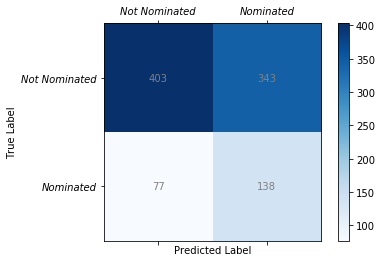

Precision 28.6902% | Recall 64.1860%


In [22]:
model = Linear_GNN(in_feats, out_feats, hidden_size)
#model = Simple_APPNP(in_feats, out_feats, 6, k)

loss_fcn = torch.nn.CrossEntropyLoss(weight=weights_loss)
optimizer = torch.optim.Adam(model.parameters(),lr=lr) #weight_decay=weight_decay)
losses_tr = []
accuracies_tr = []
accuracies_val = []
for epoch in range(n_epochs):
    # adapt learning rate
    if epoch == 100: 
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr2
    elif epoch == 300: 
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr3
    
    loss = train(model, G, tensor_data, tensor_labels, train_mask, loss_fcn, optimizer)
    losses_tr.append(loss.item())
    #accuracies_tr.append(acc)
    pre, rec, f1, sup, C = evaluate(model, G, tensor_data, val_mask, tensor_labels)
    #accuracies_val.append(acc)
    if (epoch+1)%50 == 0:
        print("Epoch {:05d} | Train Loss {:.4f} | Val precision {:.4%} | Val recall {:.4%}". format(epoch+1, loss.item(), pre, rec))

print()
print('Test')
pre, rec, f1, sup, C = evaluate(model, G, tensor_data, test_mask, tensor_labels)
confusion_matrix(C)
print("Precision {:.4%} | Recall {:.4%}". format(pre, rec))

### Results of Graph CNN Optimisation : 

- APP Conv : with or without linear layer added generates a linearly decreasing loss and associated linearly decreasing accuracy with no good repartition of error between classes, difficulty to learn
- GCNN without linear layers: more unstable results, no learning 
- GCNN with linear layers: linear layer at the beginning help stabilize and learn, a second linear layer in front doesn't create significant impact |no linear layer at the end no learning, second linear layer at the end reduces learning/less balanced errors, performance around 75%
- Number of CNN layers: the addition of layers helps stabilize the learning accross epochs, when 4/5 layers less stables hence ~66% with more balanced, when 10/11 layers after 200 epochs very stales, errors not balanced at all
- Add dropout, increase instability, when in a max -> strong acc, bad repartition, when in a min, the opposite => removed 
- Addition of a Avgpooling layer: no significant improvement on accuracy or error repartition 
- Hidden layer size for GCNN: if increase layer size increase creates instability but at a certain extend balances the errors in classes, around 60
- Hidden layer size for final linear layer: 30, tradeoff with error-accuracy
- Cross entropy + Soft Max give very unstable results over trials, converge to all 0 or all 1
- NLL loss with log_sofmax gives very unstable results over epochs but reaches learning
- Adding weights to loss function does generate improvement 
- BCE Loss not appropriate
- Number of epochs, no need to go above 250, stabilisation around 200/250

=> if stable , accuracy around 75%, very unbalanced errors
=> if unstable (less layers, dropout ...), accuracy around 60%, more balanced errors 
